# Filter and order

### Imports

In [1]:
%load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /mnt/home/pleung/projects/grad_reqs
running on node: dig57


### Insert the root of the crispy_shifty repo

In [2]:
sys.path.insert(0, "/projects/crispy_shifty")

### Filter docks

In [3]:
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "04_filter"
design_list_file = os.path.join(os.getcwd(), "03_redock_ligand/redocked_binders.list")
output_path = os.path.join(os.getcwd(), f"{simulation_name}")
options = " ".join(
    [
        "out:level 200",
        "keep_input_protonation_state true",
        "extra_res_fa /home/pleung/projects/grad_reqs/04_filter/AFO_0001_linker_tors.params",
    ]
)

extra_kwargs = {
    "atom_ids": "O6,C18,H14,H16,CX20,OX31,NX28,HX29,CX23,HX24,HX34,CX21,HX22,HX33,CX25,HX26,HX27,HX35",
}

gen_array_tasks(
    distribute_func="deployables.check_linker_accessibility",
    func_root="/home/pleung/projects/grad_reqs",
    design_list_file=design_list_file,
    output_path=output_path,
    queue="short",
    memory="4G",
    nstruct=1,
    nstruct_per_task=10,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
)

https://docs.anaconda.com/anaconda/install

Run the following command with your desired environment active:
sbatch -a 1-7128 /mnt/home/pleung/projects/grad_reqs/04_filter/run.sh


### Collect scorefiles of the filtered docks

In [3]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "04_filter"
output_path = os.path.join(os.getcwd(), f"{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

https://docs.anaconda.com/anaconda/install



### Load resulting concatenated scorefile

In [4]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

output_path = os.path.join(os.getcwd(), f"{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

### Dump scores_df as a CSV and then reload, for performance reasons

In [5]:
if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col="Unnamed: 0")

### Setup for plotting

In [6]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### Data exploration

In [7]:
print(len(scores_df))
print(list(scores_df.columns))

71279
['cms', 'dH', 'ddg', 'design_type', 'designed_by', 'dslf_fa13', 'elapsed_time', 'fa_atr', 'fa_dun', 'fa_dun_dev', 'fa_dun_rot', 'fa_dun_semi', 'fa_elec', 'fa_intra_atr_xover4', 'fa_intra_elec', 'fa_intra_rep', 'fa_intra_rep_xover4', 'fa_intra_sol_xover4', 'fa_rep', 'fa_rmsd', 'fa_sol', 'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc', 'hbond_sr_bb', 'hxl_tors', 'lig_rms', 'ligandname', 'ligscore', 'linker_burial', 'lk_ball', 'lk_ball_bridge', 'lk_ball_bridge_uncpl', 'lk_ball_iso', 'lk_ball_wtd', 'mean_pae', 'mean_pae_interaction', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_plddt', 'model', 'omega', 'pTMscore', 'p_aa_pp', 'path_in', 'pro_close', 'rama_prepro', 'ranking_prerelax', 'recscore', 'recycles', 'ref', 'rmsd_to_reference', 'score', 'seed', 'tol', 'total_score', 'type', 'yhh_planarity']


In [8]:
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

### Plot linker metrics

3it [00:00,  5.32it/s]


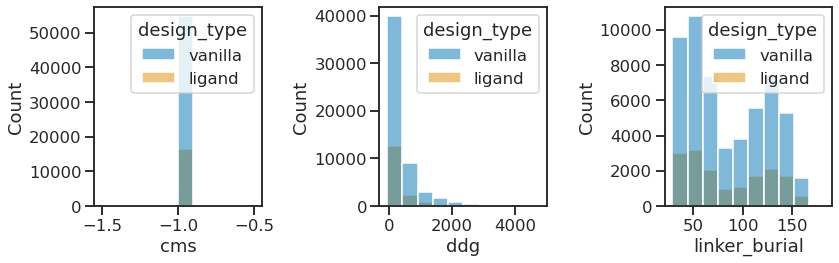

In [9]:
cols = [
    "cms",
    "ddg",
    "linker_burial",
]
the_fig = histplot_df(
    df=scores_df,
    cols=cols,
    bins=10,
    hue="design_type",
)
plt.savefig(os.path.join(output_path, "ligand_scores.png"))

<Figure size 864x864 with 0 Axes>

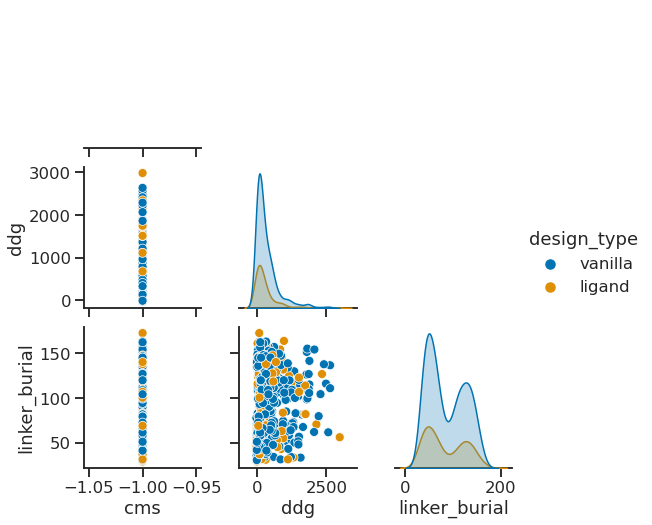

In [10]:
the_fig = pairplot_df(
    df=scores_df.sample(1000, random_state=0),
    cols=cols,
    hue="design_type",
)
plt.savefig(os.path.join(output_path, "ligand_scores_paired.png"))

### Filter the whole df

In [11]:
query = "linker_burial < 65"

filtered = scores_df.query(query)
len(filtered)

30726

### Save a list of outputs
Sort by length

In [12]:
simulation_name = "04_filter"
output_path = os.path.join(os.getcwd(), f"{simulation_name}")

with open(os.path.join(output_path, "filtered_on_linker.list"), "w") as f:
    for path in tqdm(filtered.index):
        print(path, file=f)

  0%|          | 0/30726 [00:00<?, ?it/s]

### Refilter docks

In [14]:
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "04_refilter"
design_list_file = os.path.join(os.getcwd(), "04_filter/filtered_on_linker.list")
output_path = os.path.join(os.getcwd(), f"{simulation_name}")
options = " ".join(
    [
        "out:level 200",
        "corrections:beta true",
        "extra_res_fa /home/pleung/projects/grad_reqs/00_pack_around_ligand/afo.params",
    ]
)

gen_array_tasks(
    distribute_func="deployables.refilter",
    func_root="/home/pleung/projects/grad_reqs",
    design_list_file=design_list_file,
    output_path=output_path,
    queue="short",
    memory="4G",
    nstruct=1,
    nstruct_per_task=50,
    options=options,
    simulation_name=simulation_name,
)

Run the following command with your desired environment active:
sbatch -a 1-1537 /mnt/home/pleung/projects/grad_reqs/04_refilter/run.sh


### Collect scorefiles of the filtered docks

In [15]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "04_refilter"
output_path = os.path.join(os.getcwd(), f"{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

### Load resulting concatenated scorefile

In [16]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

output_path = os.path.join(os.getcwd(), f"{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

  0%|          | 0/20 [00:00<?, ?it/s]

### Dump scores_df as a CSV and then reload, for performance reasons

In [17]:
if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col="Unnamed: 0")

### Setup for plotting

In [18]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### Data exploration

In [19]:
print(len(scores_df))
print(list(scores_df.columns))

20
['cms', 'dH', 'ddg', 'design_type', 'designed_by', 'dslf_fa13', 'elapsed_time', 'fa_atr', 'fa_dun', 'fa_dun_dev', 'fa_dun_rot', 'fa_dun_semi', 'fa_elec', 'fa_intra_atr_xover4', 'fa_intra_elec', 'fa_intra_rep', 'fa_intra_rep_xover4', 'fa_intra_sol_xover4', 'fa_rep', 'fa_rmsd', 'fa_sol', 'gen_bonded', 'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc', 'hbond_sr_bb', 'hxl_tors', 'lig_rms', 'ligandname', 'ligscore', 'linker_burial', 'lk_ball', 'lk_ball_bridge', 'lk_ball_bridge_uncpl', 'lk_ball_iso', 'lk_ball_wtd', 'mean_pae', 'mean_pae_interaction', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_plddt', 'model', 'omega', 'pTMscore', 'p_aa_pp', 'path_in', 'pro_close', 'rama_prepro', 'ranking_prerelax', 'recscore', 'recycles', 'ref', 'rmsd_to_reference', 'score', 'seed', 'tol', 'total_score', 'type', 'yhh_planarity']


In [20]:
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

### Plot ligand metrics

3it [00:00, 21.34it/s]


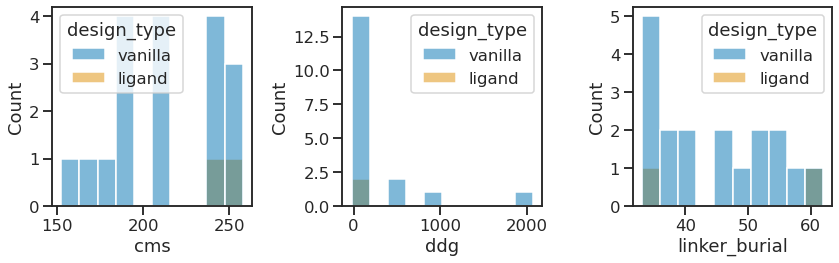

In [21]:
cols = [
    "cms",
    "ddg",
    "linker_burial",
]
the_fig = histplot_df(
    df=scores_df,
    cols=cols,
    bins=10,
    hue="design_type",
)
plt.savefig(os.path.join(output_path, "ligand_scores.png"))

In [23]:
scores_df.ddg.values

array([-4.37425732e+00, -8.98437566e+00,  3.94238408e+01,  1.02251736e+03,
        3.50037680e+01, -1.04956563e+01,  6.29556753e+01,  1.93965536e+01,
        1.52085812e+01, -2.37939648e+01,  4.27581600e+02,  5.36508651e+02,
        2.07439476e+03,  1.35550400e+02, -1.85633766e+00, -2.35416932e+01,
       -8.79052163e+00, -2.42317782e+00, -2.09100263e+01, -1.59792137e+01])

In [22]:
the_fig = pairplot_df(
    df=scores_df.sample(1000, random_state=0),
    cols=cols,
    hue="design_type",
)
plt.savefig(os.path.join(output_path, "ligand_scores_paired.png"))

ValueError: Cannot take a larger sample than population when 'replace=False'

### Prototyping blocks